# Análisis y predicción de riesgo crediticio
Este notebook implementa un análisis y modelado de datos de riesgo crediticio con datos de Alemania.

In [81]:
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from typing import Dict, Tuple, Optional, Any
from sklearn.base import BaseEstimator
import warnings

warnings.filterwarnings('ignore')

## Diccionario de datos
- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (text - little, moderate, quite rich, rich)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
- Risk (text: good, bad)

## Cargar datos

In [82]:
df = pd.read_csv('german_credit_data.csv')

## Analisis exploratorio

Principales hallazgos:
- Missing values en las variables de las cuentas se refieren a que la persona no tiene ese tipo de cuenta, por lo que se rellenara con 0
- Las personas mas jovenes suelen pedir prestamos mas grandes relativamente a la personas mas grandes
- Las personas mas jovenes y las mas ancianas son las que tienen el mayor ratio de deuda de riesgo alto
- Estos son los grupos que mas probabilidad tienen de estar desempleados o subempleados
- Mientras mas alta sea la riqueza de los individuos (medida en base a su savings account), menor sera la probabilidad de tener riesgo malo
- Tenemos una relacion de aproximadamente 2 hombres por cada mujer en la data
- Mientras mas alto sea el tamaño del credito, mas alto sera el riesgo
- Tenemos clases desbalanceadas en la variable target, usaremos distintos pesos en la funcion de perdida del modelo para penalizar que el modelo prediga mal el bad credit
- Contamos con la presencia de un gran numero de outliers, por lo que entrenaremos un modelo de arbol, robusto a estos.

In [83]:
df.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [85]:
df['Job'] = df['Job'].astype('object')
df.drop('Unnamed: 0', axis=1, inplace=True)
df['Risk'] = df['Risk'].map({'bad': 1, 'good': 0})
df.reset_index(drop=True, inplace=True)

In [86]:
df.describe()

,Age,Credit amount,Duration,Risk
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,3271.258000,20.903000,0.300000
std,11.375469,2822.736876,12.058814,0.458487
min,19.000000,250.000000,4.000000,0.000000
25%,27.000000,1365.500000,12.000000,0.000000
50%,33.000000,2319.500000,18.000000,0.000000
75%,42.000000,3972.250000,24.000000,1.000000
max,75.000000,18424.000000,72.000000,1.000000


### Explorar missing values

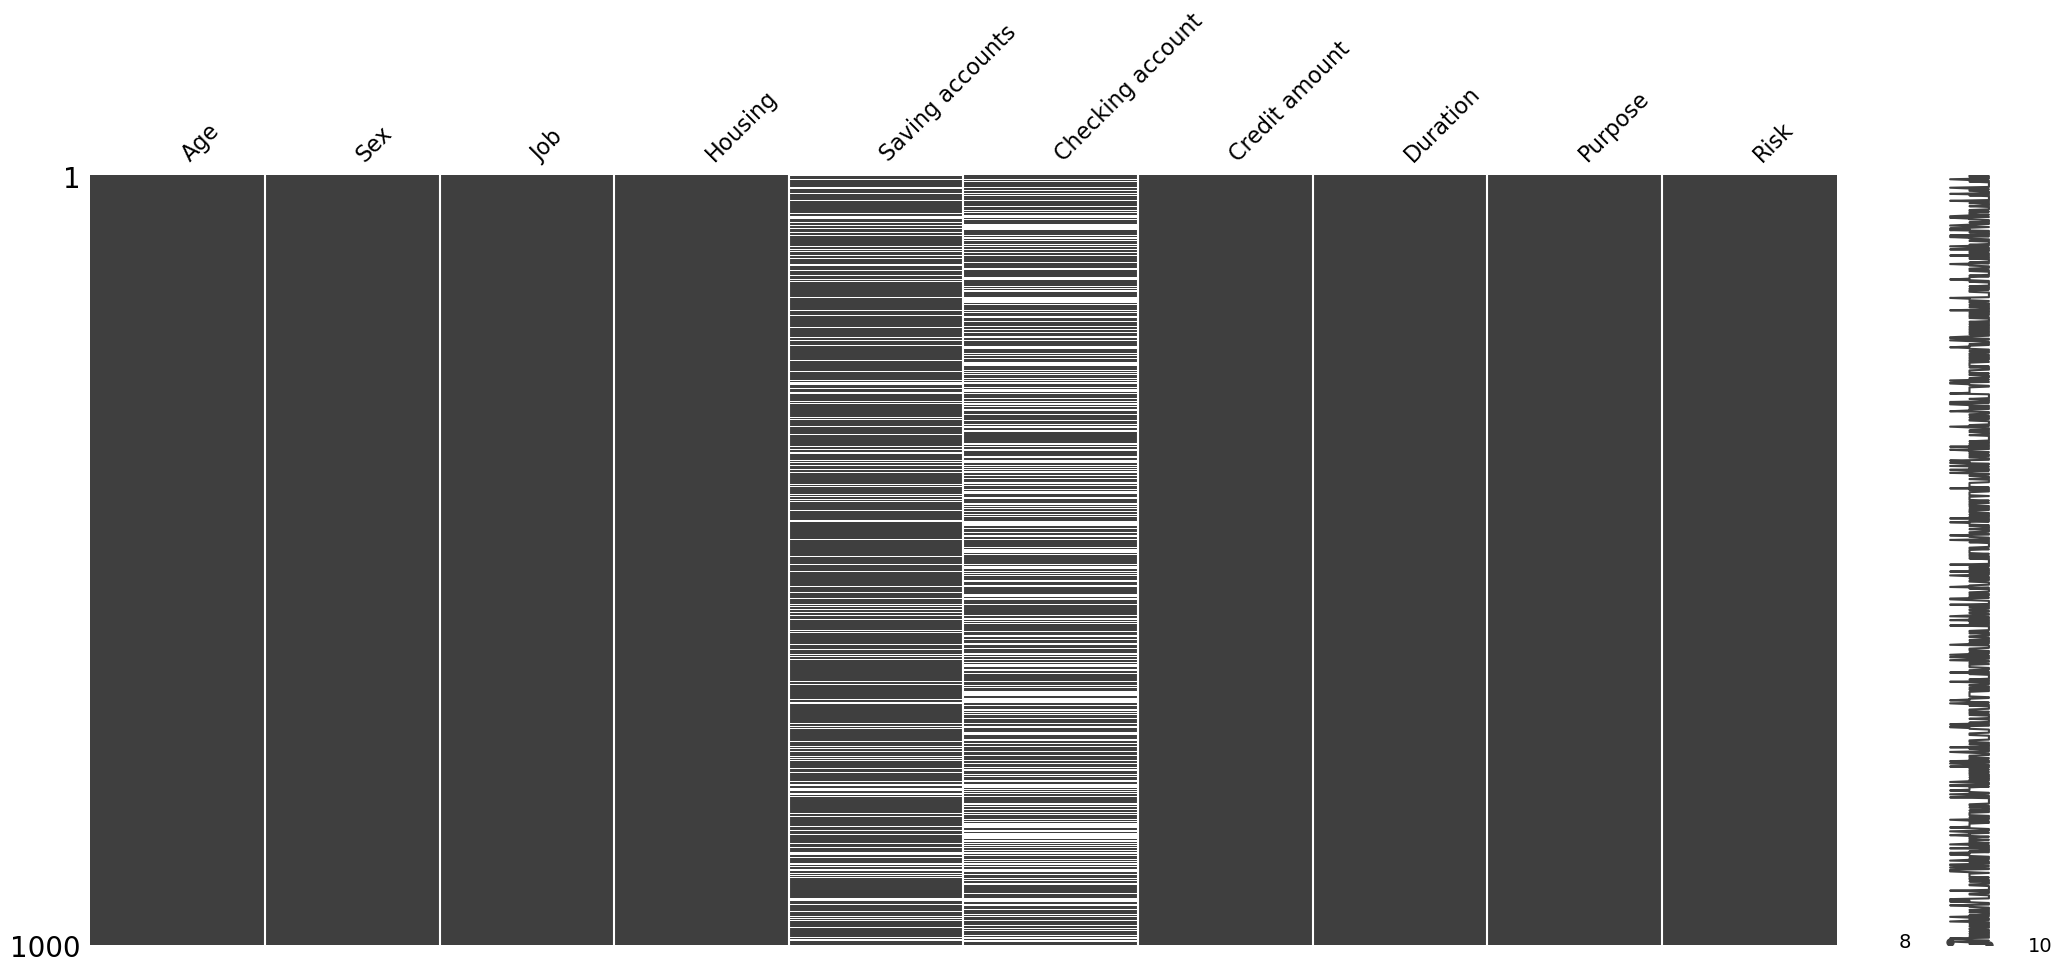

In [87]:
msno.matrix(df)
plt.show()

In [88]:
df.isnull().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

### Asumiremos que los missing values en las cuentas se refieren a que no tienen ese tipo de cuentas, por lo que rellenaremos los missing values con 0

<Axes: xlabel='Saving accounts,Checking account'>

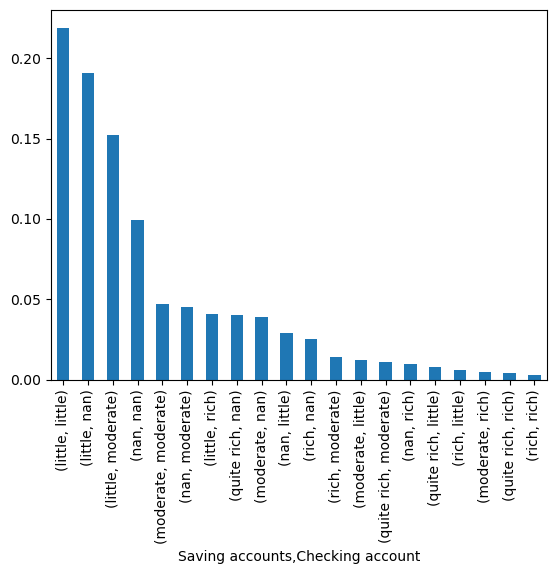

In [89]:
df[['Saving accounts', 'Checking account']].value_counts(normalize=True, dropna=False).plot(kind='bar')


### Correlacion entre variables

Se observa correlacion significativa entre tamaño del credito y duracion

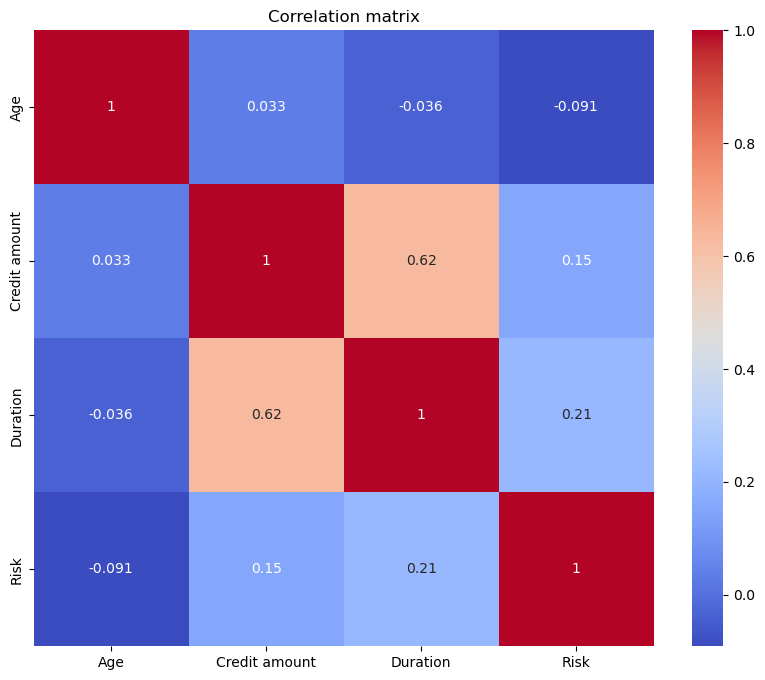

In [90]:
numeric_df = df.select_dtypes(include=[np.number])
category_df = df.select_dtypes(include=[object])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

### Anlisis target

2024-12-06 17:17:08,599 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-06 17:17:08,610 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


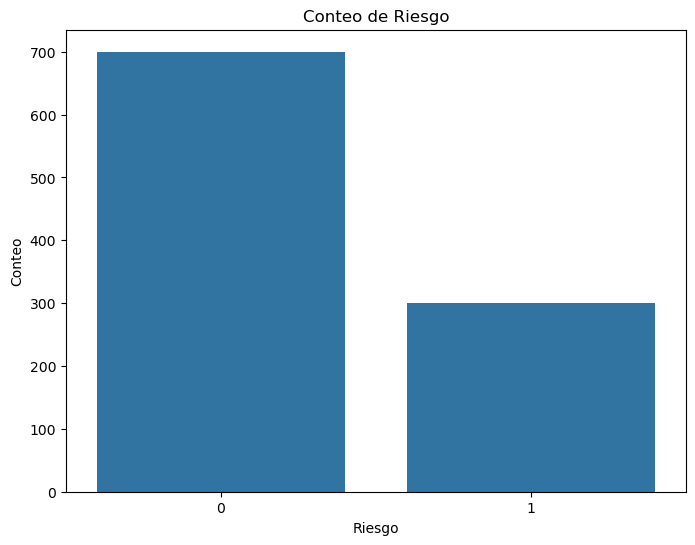

In [91]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Risk')
plt.title('Conteo de Riesgo')
plt.xlabel('Riesgo')
plt.ylabel('Conteo')
plt.show()

### Distribuciones de las variables numericas

Las 3 variables tienen un fuerte skew a la derecha

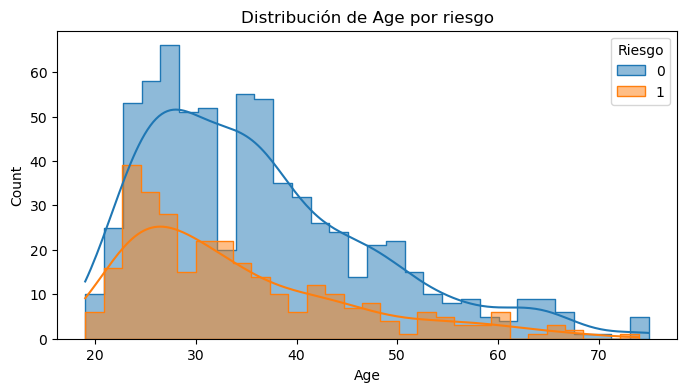

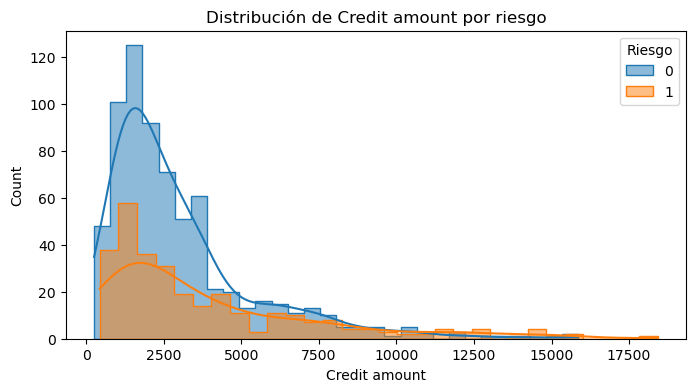

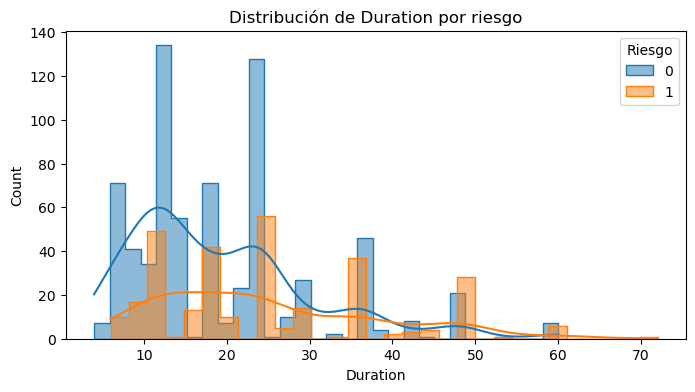

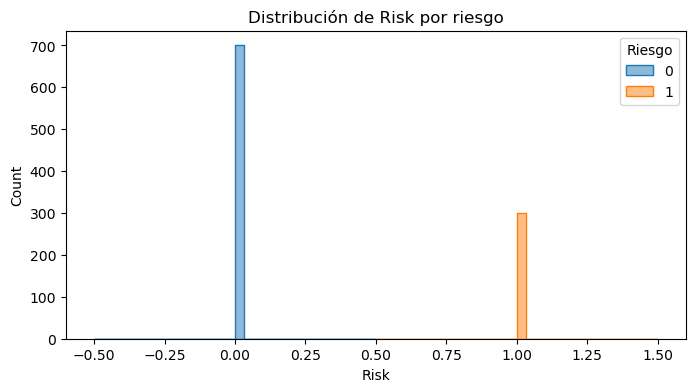

In [92]:
for col in numeric_df.columns:
    plt.figure(figsize=(8, 4))
    for label in df['Risk'].unique():
        sns.histplot(df[df['Risk'] == label][col], kde=True, bins=30, label=label, element='step', fill=True)
    plt.title(f'Distribución de {col} por riesgo')
    plt.legend(title='Riesgo')
    plt.show()

## Analizamos mas profundamente la edad

Usaremos 4 bins para agrupar a las personas por edad

In [93]:
df['Age_Group'] = np.nan

lst = [df]

for col in lst:
    col.loc[(col['Age'] > 18) & (col['Age'] <= 29), 'Age_Group'] = 'Jovenes'
    col.loc[(col['Age'] > 29) & (col['Age'] <= 40), 'Age_Group'] = 'Jovenes adultos'
    col.loc[(col['Age'] > 40) & (col['Age'] <= 55), 'Age_Group'] = 'Senior'
    col.loc[col['Age'] > 55, 'Age_Group'] = 'Ancianos'

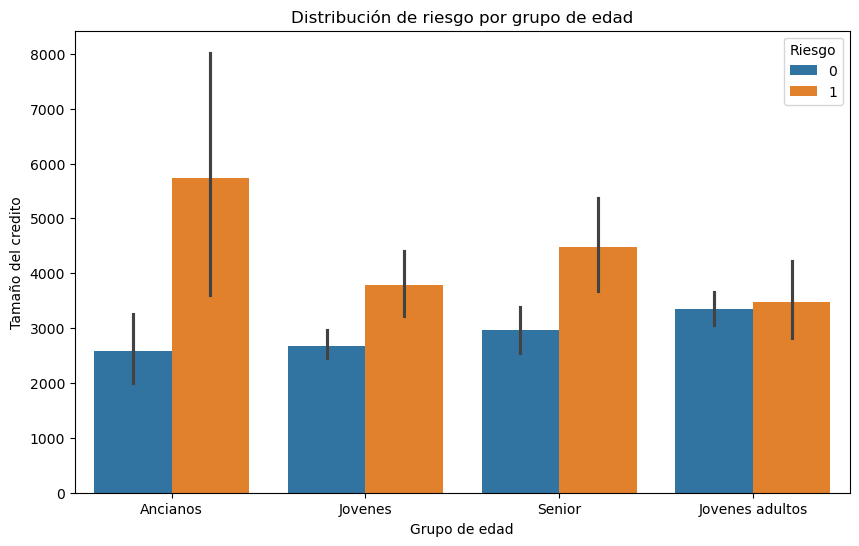

In [94]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='Age_Group', hue='Risk', y='Credit amount')
plt.title('Distribución de riesgo por grupo de edad')
plt.xlabel('Grupo de edad')
plt.ylabel('Tamaño del credito')
plt.legend(title='Riesgo')
plt.show()

### Riesgo por riqueza

Se oberva una relacion negativa entre riqueza y riesgo malo

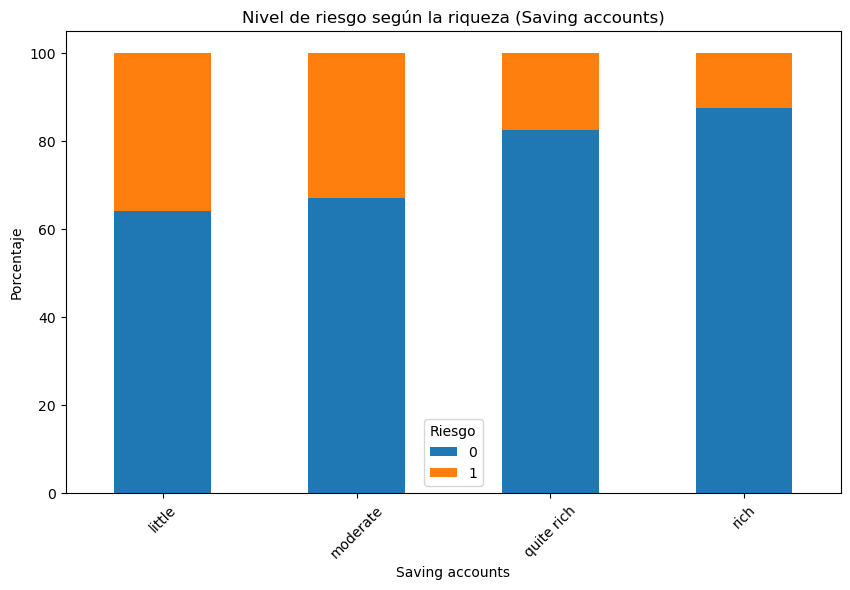

In [95]:
saving_risk_ct = pd.crosstab(df['Saving accounts'], df['Risk'], normalize='index') * 100

saving_risk_ct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Nivel de riesgo según la riqueza (Saving accounts)')
plt.xlabel('Saving accounts')
plt.ylabel('Porcentaje')
plt.legend(title='Riesgo')
plt.xticks(rotation=45)
plt.show()

### Features numericas contra numericas

Mientras mas alto sea el tamaño del credito, mas alto sera el riesgo

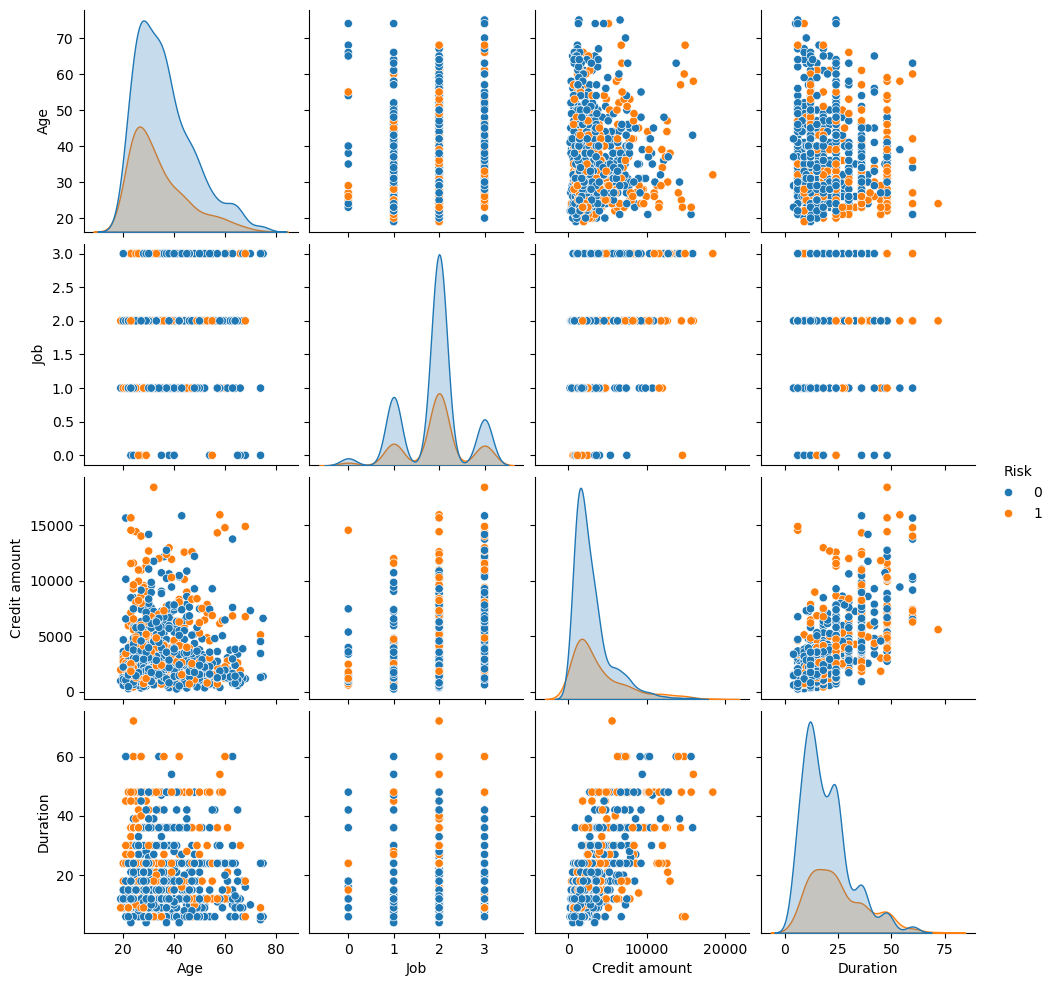

In [96]:
sns.pairplot(df, hue='Risk')
plt.show()

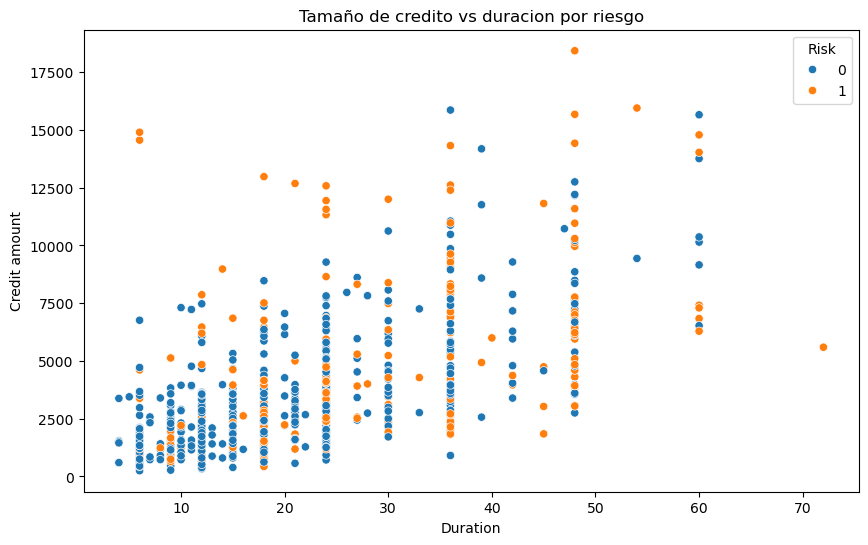

In [97]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Duration', y='Credit amount', hue='Risk')
plt.title('Tamaño de credito vs duracion por riesgo')
plt.xlabel('Duration')
plt.ylabel('Credit amount')
plt.legend(title='Risk')
plt.show()

## Analisis features categoricas

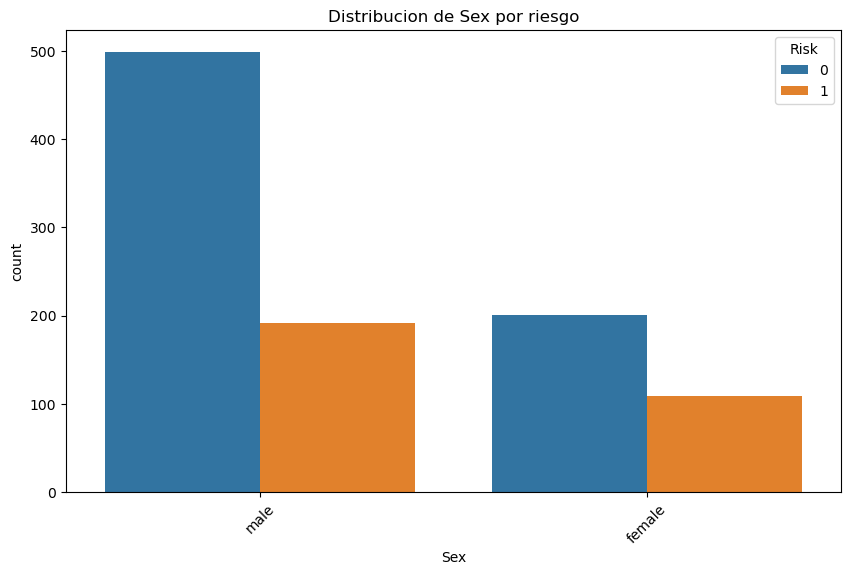

2024-12-06 17:17:16,984 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-06 17:17:16,997 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


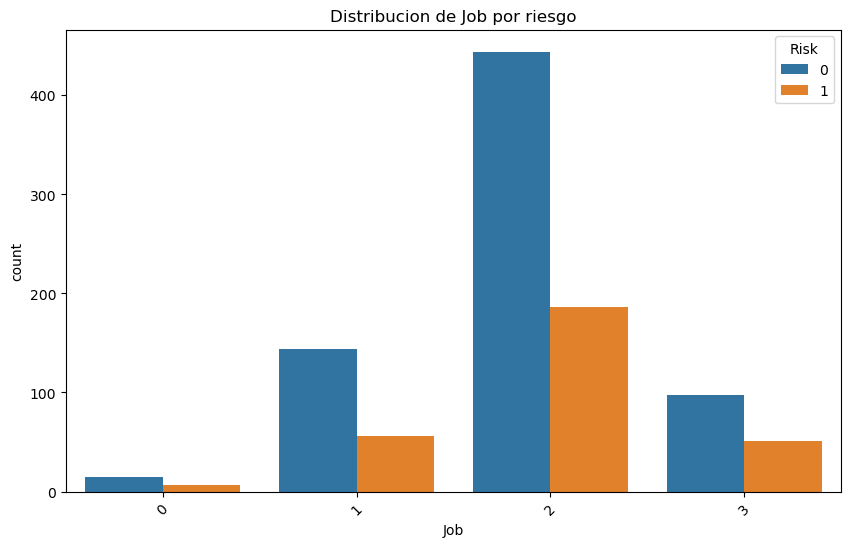

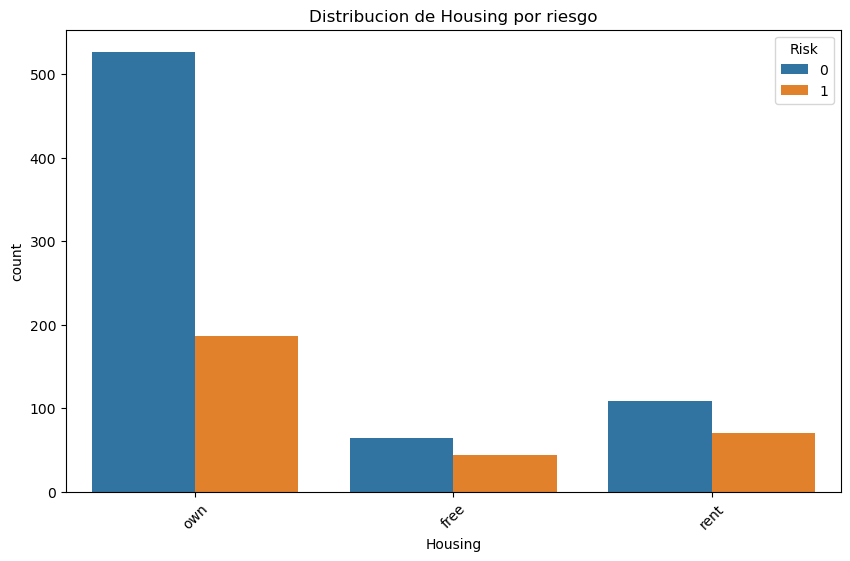

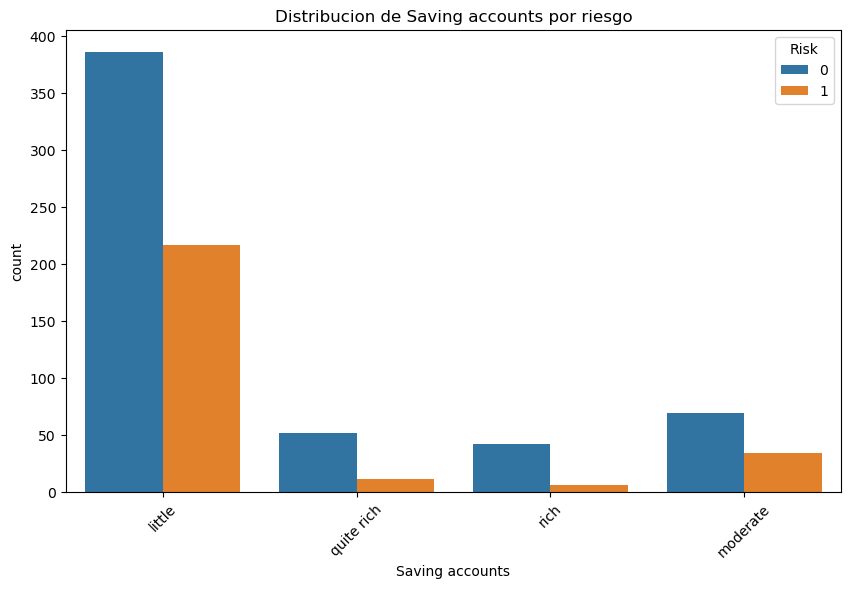

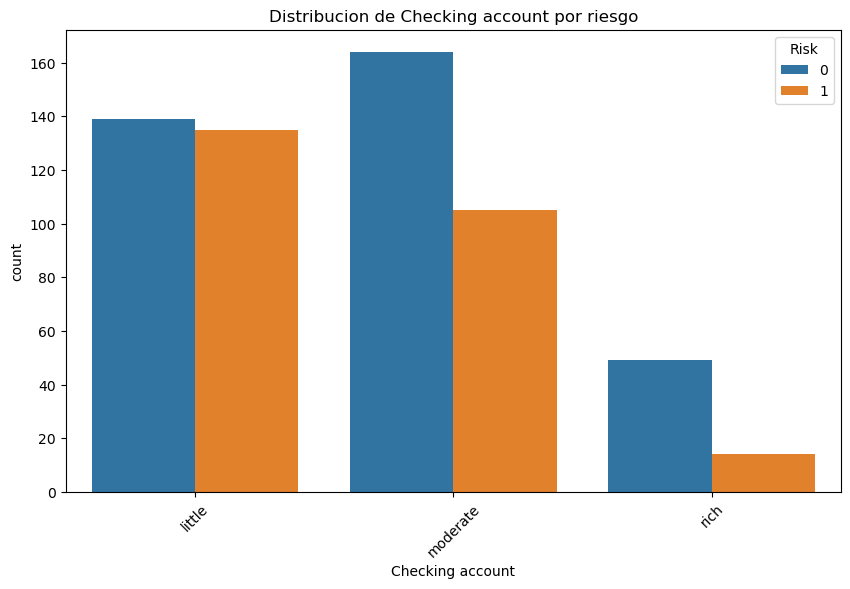

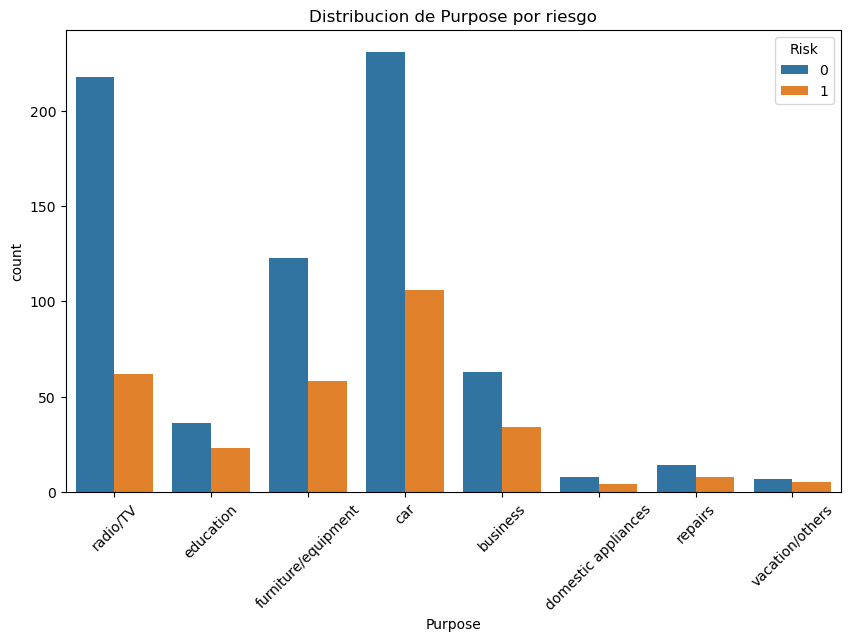

In [98]:
for col in category_df.columns:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='Risk')
    plt.title(f'Distribucion de {col} por riesgo')
    plt.xticks(rotation=45)
    plt.show()

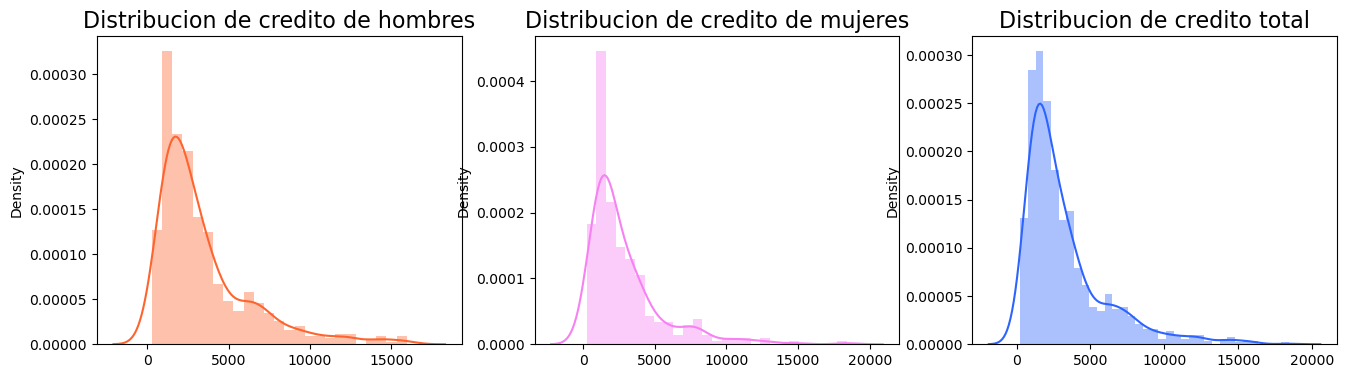

In [99]:
male_credit = df["Credit amount"].loc[df["Sex"] == "male"].values
female_credit = df["Credit amount"].loc[df["Sex"] == "female"].values
total_credit = df['Credit amount'].values

fig, ax = plt.subplots(1, 3, figsize=(16,4))

sns.distplot(male_credit, ax=ax[0], color="#FE642E")
ax[0].set_title("Distribucion de credito de hombres", fontsize=16)
sns.distplot(female_credit, ax=ax[1], color="#F781F3")
ax[1].set_title("Distribucion de credito de mujeres", fontsize=16)
sns.distplot(total_credit, ax=ax[2], color="#2E64FE")
ax[2].set_title("Distribucion de credito total", fontsize=16)
plt.show()

### Outliers

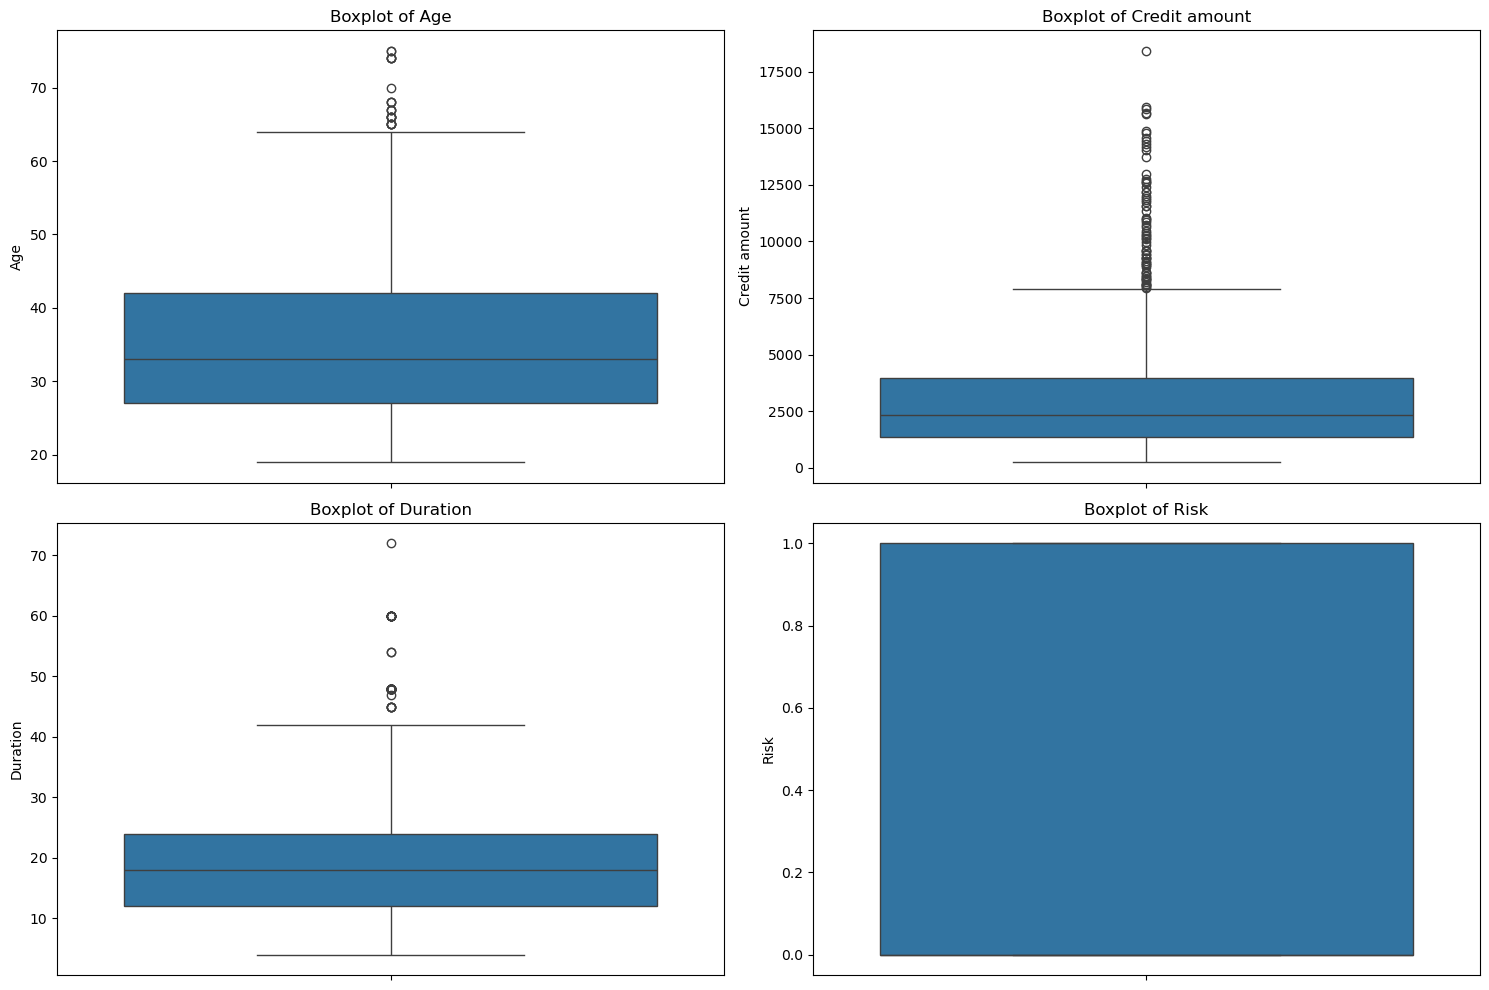

In [100]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_df.columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=numeric_df, y=col)
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

### Features numericas contra categoricas

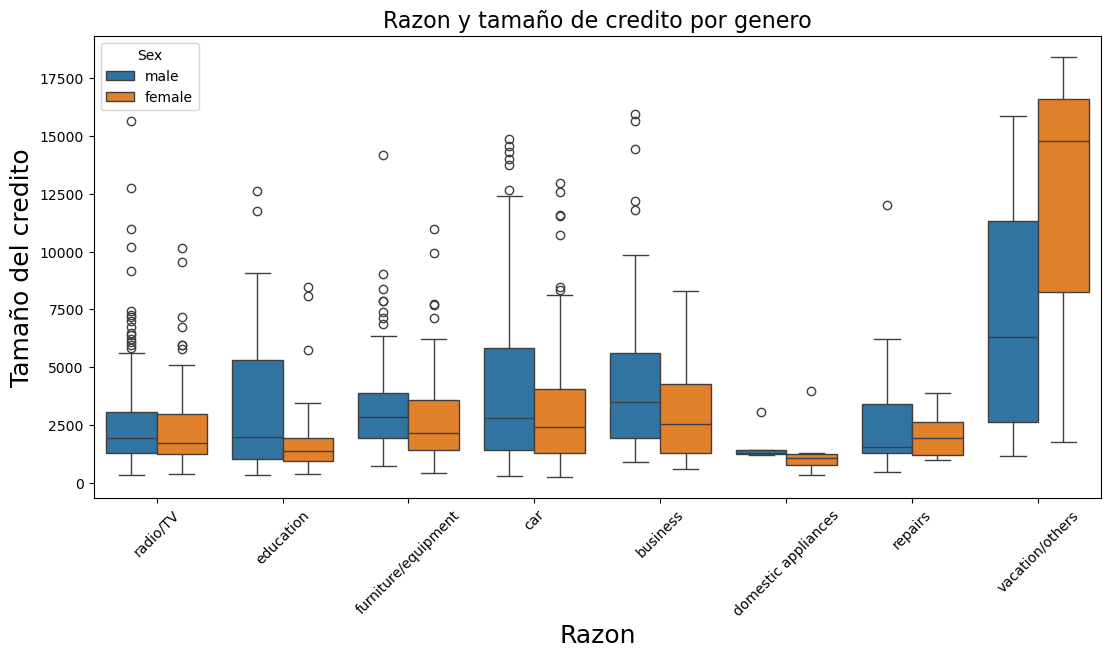

In [101]:
plt.figure(figsize=(13,6)) #figure size
g = sns.boxplot(x='Purpose', y='Credit amount', hue='Sex',
                data=df)


g.set_title("Razon y tamaño de credito por genero", fontsize=16)
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel('Razon', fontsize=18)
g.set_ylabel('Tamaño del credito', fontsize=18) 
plt.show()

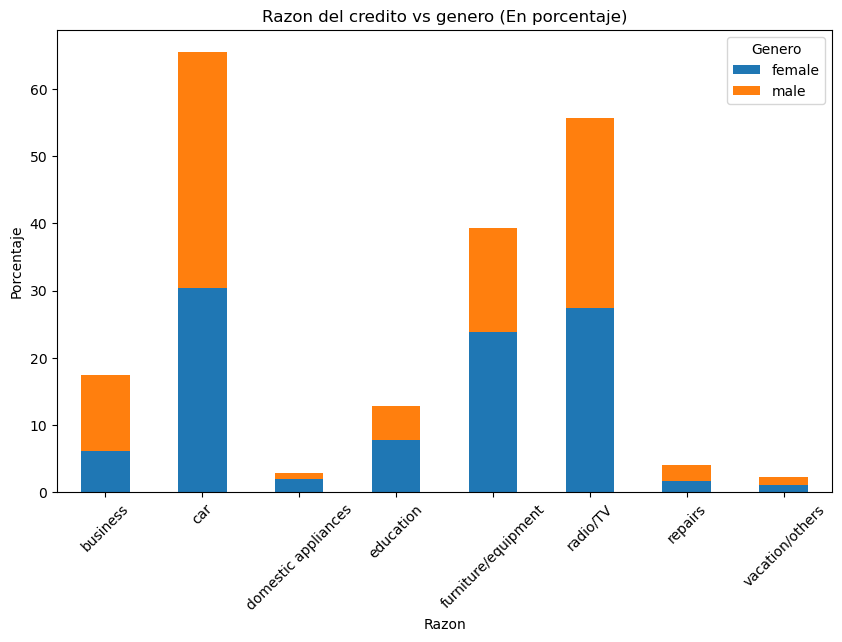

In [102]:
purpose_gender_ct = pd.crosstab(df['Purpose'], df['Sex'], normalize='columns') * 100

purpose_gender_ct.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Razon del credito vs genero (En porcentaje)')
plt.xlabel('Razon')
plt.ylabel('Porcentaje')
plt.legend(title='Genero')
plt.xticks(rotation=45)
plt.show()

## Clase para procesar, entrenar, evaluar y hacer predicciones

In [103]:
class CreditRiskAnalysis:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None
        self.processed_data = None
        self.best_params_ = None

    def load_data(self):
        """Carga y muestra información básica de los datos"""
        self.data = pd.read_csv(self.file_path)
        print('Datos cargados')
        display(self.data.head())
        display(self.data.info())

    def preprocess_data(self):
        """Preprocesa los datos manejando nulos y codificando categóricas"""
        df = self.data.copy()
        df['Saving accounts'].fillna('desconocido', inplace=True)
        df['Checking account'].fillna('desconocido', inplace=True)
        df.drop('Unnamed: 0', axis=1, inplace=True)
        df = pd.get_dummies(df, columns=['Purpose', 'Housing', 'Saving accounts', 'Checking account', 'Job'], dtype=int)
        df['Sex'] = df['Sex'].map({'female': 1, 'male': 0})
        df['Risk'] = df['Risk'].map({'bad': 1, 'good': 0})
        self.processed_data = df
        print('Datos preprocesados')
        display(self.processed_data.head())

    def prepare_data_for_modeling(self):
        """Prepara datos para modelado"""
        X = self.processed_data.drop(columns=['Risk'])
        y = self.processed_data['Risk']
        return train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

    def train_model(self, X_train, y_train, **kwargs):
        """Entrena un modelo de clasificación"""
        model = RandomForestClassifier(class_weight='balanced', **kwargs)
        model.fit(X_train, y_train)
        return model

    def evaluate_model(self, model, X_test, y_test):
        """Evalúa el modelo y genera reportes"""
        y_pred = model.predict(X_test)
        print(classification_report(y_test, y_pred))
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()
    
    def optimize_model(self, X_train, y_train, X_test, y_test):
        """Grafica la pérdida del Random Forest por número de max_depth"""
        max_depths = range(1, 21)
        train_losses = []
        val_losses = []

        for max_depth in max_depths:
            model = RandomForestClassifier(max_depth=max_depth, random_state=23, class_weight='balanced', n_estimators=60)
            model.fit(X_train, y_train)
            train_loss = 1 - model.score(X_train, y_train)
            val_loss = 1 - model.score(X_test, y_test)
            train_losses.append(train_loss)
            val_losses.append(val_loss)

        plt.figure(figsize=(10, 6))
        plt.plot(max_depths, train_losses, label='Train Loss')
        plt.plot(max_depths, val_losses, label='Validation Loss')
        plt.xlabel('Max Depth')
        plt.ylabel('Loss')
        plt.title('Random Forest Loss por Max Depth')
        plt.legend()
        plt.show()

## Flujo Principal

In [104]:
# Path de los datos
file_path = 'german_credit_data.csv'

# Instancia de la clase
analysis = CreditRiskAnalysis(file_path)

# Ejecutar flujo
analysis.load_data()
analysis.preprocess_data()
X_train, X_test, y_train, y_test = analysis.prepare_data_for_modeling()

Datos cargados


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


None

Datos preprocesados


,Age,Sex,Credit amount,Duration,Risk,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,...,Saving accounts_quite rich,Saving accounts_rich,Checking account_desconocido,Checking account_little,Checking account_moderate,Checking account_rich,Job_0,Job_1,Job_2,Job_3
0,67,0,1169,6,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,22,1,5951,48,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,49,0,2096,12,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
3,45,0,7882,42,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
4,53,0,4870,24,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


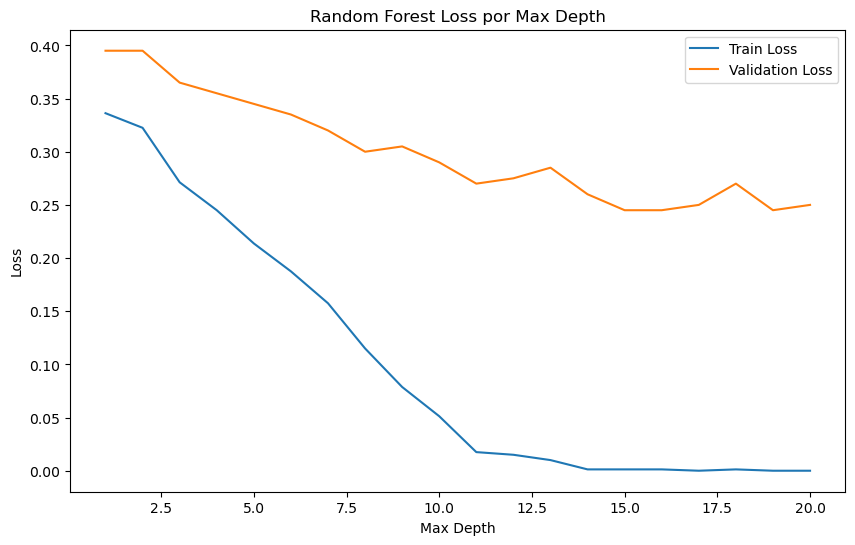

In [105]:
# Buscar mejor max depth
analysis.optimize_model(X_train, y_train, X_test, y_test)

              precision    recall  f1-score   support

           0       0.83      0.82      0.82       140
           1       0.59      0.60      0.60        60

    accuracy                           0.76       200
   macro avg       0.71      0.71      0.71       200
weighted avg       0.76      0.76      0.76       200



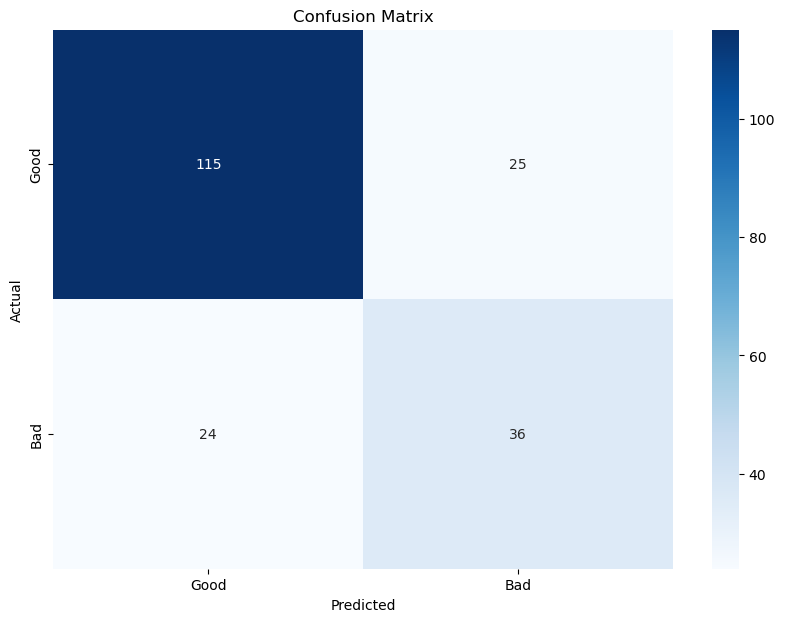

In [106]:
# Entrenar y evaluar modelo
model = analysis.train_model(X_train, y_train, max_depth=12, n_estimators=60)
analysis.evaluate_model(model, X_test, y_test)

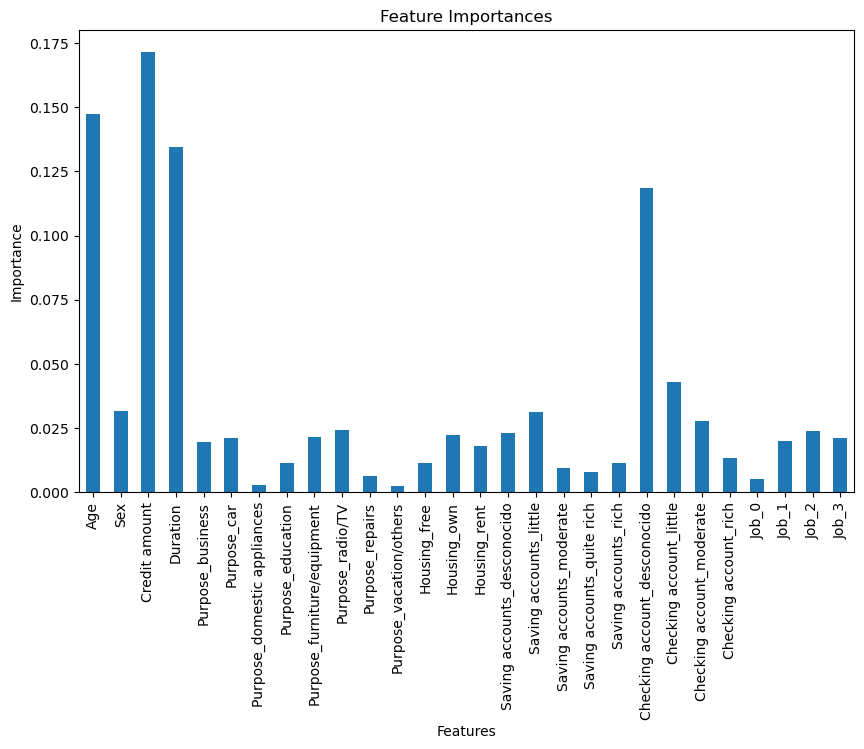

In [107]:

# Convert the feature importances to a pandas Series
feature_importances = pd.Series(model.feature_importances_, index=X_train.columns)

# Plot the feature importances
feature_importances.plot(kind='bar', figsize=(10, 6))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

## Con una gran diferencia, los mejores predictores de risk son la edad, el tamaño del credito, la duracion y si no tiene checking account